# Aaron Szabo

Please replace first_name and last_name with your information. This notebook will be your template that you should follow for this project. Feel free to create any subsections within each section.

## Section 0: Loading the data

There is no code for you to fill out in this section but please make sure you understand what the code* is doing so you aren't confused in later parts. Basically, this section loads the training, testing, and validation data of the dog images for you.

In [1]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image

from keras import applications
from keras import optimizers
from keras_tqdm import TQDMCallback
from keras.preprocessing.image import ImageDataGenerator

C:\Users\Szabo\Anaconda3\envs\cmsc389\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loads the datasets and gets list of dog names (labels). `X_train`, `X_val`, and `X_test` contain lists of image paths to the data.

In [2]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

X_train, y_train = load_dataset('dogImages/train')
X_val, y_val = load_dataset('dogImages/valid')
X_test, y_test = load_dataset('dogImages/test')

print(X_val.shape)

# List of all dog names
labels = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

(835,)


`load_image` takes in a string containing a path to an image, loads the image file, converts it into a array matrix, resizes it go be `64x64`, and normalizes all the values to be between 0 and 1.

In [3]:
def load_image(path, size=64):
    img = Image.open(path.strip())
    img = np.array(img, np.float32)
    img = scipy.misc.imresize(img, (size, size))
    return img

C:\Users\Szabo\Anaconda3\envs\cmsc389\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


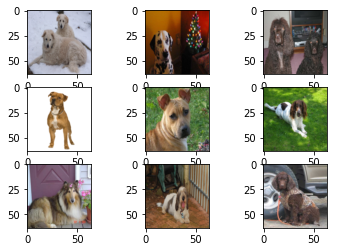

In [4]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(load_image(X_train[i]))
# show the plot
pyplot.show()

## Section 1: Data augmentation

In this section we want you to perform some sort of data augmentation as we learnt about in class. This is because we only have roughly 200 examples per label which in deep learning isn't generally enough. Therefore, to improve performance we can use data augmentation as a trick to generate more training examples.

Make sure you try at least **TWO** methods of augmentation. Please explain each augmentation and what it does as well as visualizing at least one example of each augmentation. If you do choose to try more, make sure to incremement `NB_AUGMENTATIONS` by one each time.

If you want to change the size of your image (smaller images train faster), you want to change `IMG_SIZE`.

An example augmentation of flipping the image has already been done for you in `example_augment`.

In [5]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

**Augmentation Explanation:** This augmentation darkens the image

In [6]:
def augmentation_1(img):
    
    augmented_img = img
    for x in range(64):
        for y in range(64):
            for z in range(3):
                augmented_img[x][y][z] *= 1/2
    
    return augmented_img

**Augmentation Explanation:** This augmentation lights the image and darkens the background

In [7]:
def augmentation_2(img):
    
    augmented_img = img
    for x in range(64):
        for y in range(64):
            for z in range(3):
                temp = augmented_img[x][y][z]
                temp = (255-temp)*1/2
                augmented_img[x][y][z] += temp
    
    return augmented_img

C:\Users\Szabo\Anaconda3\envs\cmsc389\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


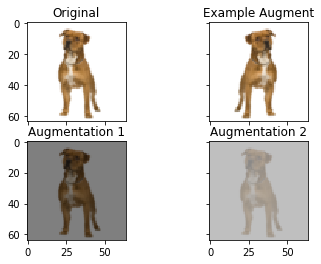

In [8]:
sample_img = load_image(X_train[3])
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()

In [9]:
NB_AUGMENTATIONS = 3
IMG_SIZE = 64

def batch_generator(images, labels, augment=True, batch_size=16):
    batch_images = []
    batch_labels = []
    sample_count = 0
    
    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):

            img_path = images[i]
            label = labels[i]

            img = load_image(img_path, size=IMG_SIZE)
            batch_images.append(img)
            batch_labels.append(label)
            sample_count += 1

            if augment:
                # Perform Augmentation (Flipping the Image)
                img_example_augment = example_augment(img)
                batch_images.append(img_example_augment)
                batch_labels.append(label)
                
                # Perform Augmentation 1
                img_augment_1 = augmentation_1(img)
                batch_images.append(img_augment_1)
                batch_labels.append(label)

                # Perform Augmentation 2
                img_augment_2 = augmentation_2(img)
                batch_images.append(img_augment_2)
                batch_labels.append(label)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_labels)
                # Reset batch.
                batch_images = []
                batch_labels = []

In [10]:
NB_AUGMENTATIONS = 3
IMG_SIZE = 64

def bottle_generator(images, batch_size=16):
    bottle_images = []
    sample_count = 0
    
    while True:
        for i in range(images.shape[0]):
            img_path = images[i]
            img = load_image(img_path, size=IMG_SIZE)
            bottle_images.append(img)
            sample_count += 1
            
            img_ex_augment = example_augment(img)
            bottle_images.append(img_ex_augment)
            
            img_aug1 = augmentation_1(img)
            bottle_images.append(img_aug1)
            
            img_aug2 = augmentation_2(img)
            bottle_images.append(img_aug2)
            
            if (((sample_count % batch_size) == 0) or ((sample_count % len(images)) == 0)):
                yield np.array(bottle_images)
                # Reset batch.
                bottle_images = []

## Section 2: Building the model

In this section you will write all the code to build your Convolutional Neural Network model in Keras. The model should output `NUM_CLASSES` (133 in this case) values which sum up to 1 and are each the probability that the dog is of the respective breed.

**Explanation:** This is where I got stuck. I think I understand how to use a pre-trained model in theory. However, I could not get the custom generator to work with either approach to using a pretrained model. I attempted the approach where to load the pretrained convolutional layers, mark them as not trainable, add the top level features, and train the model as normal. However I could not figure out how to use the custom generator in that case. I then tried to directly implement the model used in the tutorial, however I kept running into bizzare errors, such as the one seen below. Going through the keras documentation, I found that most of the problomatic methods have little said about them, which made debugging much more difficult. 

In [66]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

img_size = 64
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'dogImages/train'
val_data_dir ='dogImages/valid'
nb_train_samples = 6680
nb_val_samples = 835
epochs = 50
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)
    
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))

print("start")

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_size, img_size),
batch_size = batch_size,
class_mode=None,
shuffle=False)
bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    
generator = datagen.flow_from_directory(
val_data_dir,
target_size=(img_size, img_size),
batch_size = batch_size,
class_mode=None,
shuffle=False)
bottleneck_features_val = model.predict_generator(generator, nb_val_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_val)
print("done")

start
Found 6680 images belonging to 133 classes.
417/417 [==============================] - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1:

TypeError: write() argument must be str, not bytes

In [45]:
nb_training_examples = 6680
nb_val_examples = 835
batch_size = 16

model = applications.VGG19(include_top=False, weights="imagenet", input_shape=(64,64,3))

generator_train = bottle_generator(X_train)
generator_val = bottle_generator(X_val)

print("starting")
bottleneck_features_train = model.predict_generator(generator_train, 6680//16, workers=2, verbose=1)
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)
print("finished")
bottleneck_features_validation = model.predict_generator(generator_val, 835//16, workers=2, verbose=1)
np.save(open('bottleneck_features_val.npy', 'w'), bottleneck_features_validation)
    

starting


C:\Users\Szabo\Anaconda3\envs\cmsc389\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


116/417 [=======>......................] - ETA: 24:1 - ETA: 23:0 - ETA: 21:4 - ETA: 21:2 - ETA: 20:5 - ETA: 20:4 - ETA: 20:4 - ETA: 20:3 - ETA: 20:4 - ETA: 20:3 - ETA: 20:3 - ETA: 20:2 - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 19:5 - ETA: 19:5 - ETA: 19:4 - ETA: 19:4 - ETA: 19:3 - ETA: 19:2 - ETA: 19:1 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:1 - ETA: 19:0 - ETA: 19:1 - ETA: 19:1 - ETA: 19:0 - ETA: 19:1 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA: 18:4 - ETA: 18:4 - ETA: 18:4 - ETA: 18:3 - ETA: 18:2 - ETA: 18:2 - ETA: 18:1 - ETA: 18:1 - ETA: 18:1 - ETA: 18:0 - ETA: 18:0 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:5 - ETA: 17:4 - ETA: 17:4 - ETA: 17:4 - ETA: 17:4 - ETA: 17:4 - ETA: 17:3 - ETA: 17:3 - ETA: 17:2 - ETA: 17:2 - ETA: 17:2 - ETA: 17:2 - ETA: 17:2 - ETA: 17:1 - ETA: 17:1 - ETA: 17:1 - ETA: 17:1 - ETA: 17:0 - ETA: 17:0 - ETA: 17:0 - ETA: 16:5 - ETA: 16:5 - ETA: 16:5 - ETA: 16:5 - ETA: 16:4 - ETA: 16:4 - ETA: 16:4 - ETA: 16:4 - ETA: 16:3

TypeError: float() argument must be a string or a number, not 'JpegImageFile'

In [30]:
model = Sequential()

convo_model = applications.VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))
for layer in model.layers:
    layer.trainable = False

model.add(convo_model)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(133))
model.add(Activation('softmax'))

for layer in model.layers[:1]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
__________

In [31]:
# # FOR YOU TO CHOOSE
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
loss = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Section 3: Training the model

The code to train your model has been done for you already as it is a bit different than before due to the batch generator. Notice how we set `augment` to false for the validation generator. It is important never to augment your validation nor testing data since that can bias (inflate or deflate) the accuracy scores. The code also saves your models weights in the end which we can use for testing later on so we don't have to retrain it entirely.

In [33]:
generator_train = batch_generator(X_train, y_train, augment=True)
generator_val = batch_generator(X_val, y_val, augment=False)

model.fit_generator(
        generator_train,
        steps_per_epoch= ((NB_AUGMENTATIONS+1) * len(X_train))/10,
        epochs=10,
        validation_data=generator_val,
        validation_steps=len(X_val),
        verbose=0,
        callbacks=[TQDMCallback()])

# Save the weights for grading.
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)



Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0:   0%|          | 0/2672.0 [00:00<?, ?it/s]C:\Users\Szabo\Anaconda3\envs\cmsc389\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.



Epoch: 0 - loss: 12.465, acc: 0.000:   0%|          | 1/2672.0 [00:03<2:29:51,  3.37s/it]


Epoch: 0 - loss: 12.925, acc: 0.000:   0%|          | 2/2672.0 [00:06<2:23:57,  3.24s/it]


Epoch: 0 - loss: 12.854, acc: 0.010:   0%|          | 3/2672.0 [00:09<2:21:55,  3.19s/it]


Epoch: 0 - loss: 12.540, acc: 0.023:   0%|          | 4/2672.0 [00:12<2:17:05,  3.08s/it]


Epoch: 0 - loss: 12.705, acc: 0.019:   0%|          | 5/2672.0 [00:15<2:14:49,  3.03s/it]

KeyboardInterrupt: 

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Section 4: Evaluation

In this section you will compute the accuracy of your model on the test data from Section 0. Make sure you very clearly have a cell that outputs and prints the percentage accuracy of your model. You will also include any code used to analyze the results here.

A confusion matrix would be nice but since there are so many classes it will be hard to cleanly visualize. Instead f1, precision, and recall scores for each class would be cleaner to read.

**Explanation:** FOR YOU TO FILL IN

In [ ]:
# YOUR EVALUATION CODE GOES HERE

\* Project Code inspired and taken from Udacity's AI Nanodegress https://github.com/mahavird/dog-project. All credit for the helper methods to load the dataset goes to Udacity.